# N9_4A — Agentic Re-Planning (FAST version with progress diagnostics)

This is a **shorter-to-run** version of the notebook for Section 9.4 Mini-Project A.

## What changed vs the original
- Adds a **QUICK** toggle (default: `True`) to reduce runtime.
- Adds **progress diagnostics** during evaluation and sensitivity runs.
- Adds **wall-clock timers** per budget and per sensitivity cell.
- Produces and saves summary figures to both **PDF** and **PNG** in `figs/`.

If you later want a more accurate figure, set `QUICK=False` and/or increase `N_EP`, `N_SENS`, and `budgets`.


## Notes
- Defaults adjusted so that **Method A (soft DP)** is less stochastic (`tau` smaller, `step_cost` larger) and comparisons are more informative.
- Trajectory visualization is now **one panel per method** and **only successful trajectories** are plotted.


### Additional adaptivity diagnostic
This notebook also saves an adaptivity figure to:
- `figs/agentic_replanning_adaptivity.pdf`
- `figs/agentic_replanning_adaptivity.png`


In [1]:
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility
# -------------------------
SEED = 7
rng = np.random.default_rng(SEED)

# -------------------------
# Paths
# -------------------------
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)
OUT_FIG = os.path.join(FIG_DIR, "agentic_replanning_gridworld_summary.pdf")
print("Will save summary figures to:", OUT_FIG, "and", OUT_FIG.replace('.pdf','.png'))


Will save summary figures to: figs/agentic_replanning_gridworld_summary.pdf and figs/agentic_replanning_gridworld_summary.png


In [2]:
# ------------------------------------------------------------
# QUICK toggle: set to False for more thorough runs
# ------------------------------------------------------------
QUICK = True

if QUICK:
    budgets = np.array([20, 50, 100, 200])
    N_EP = 30       # episodes per budget (was 250)
    N_SENS = 20     # episodes per (rho,k) cell (was 200)
    plan_T = 10     # planning horizon (was 20)
    T_max = 70      # max episode length (raised to reduce finite-horizon mismatch)
    B_fix = 100     # sensitivity compute budget
    progress_every = 5
else:
    budgets = np.array([20, 50, 100, 200, 400, 800])
    N_EP = 250
    N_SENS = 200
    plan_T = 20
    T_max = 80
    B_fix = 200
    progress_every = 25

print("QUICK:", QUICK)
print("budgets:", budgets)
print("N_EP:", N_EP, "N_SENS:", N_SENS, "plan_T:", plan_T, "T_max:", T_max, "B_fix:", B_fix)


QUICK: True
budgets: [ 20  50 100 200]
N_EP: 30 N_SENS: 20 plan_T: 10 T_max: 70 B_fix: 100


In [3]:
# ------------------------------------------------------------
# Gridworld definition
# ------------------------------------------------------------
ACTIONS = ["L", "R", "U", "D"]
A2D = {"L": (0, -1), "R": (0, 1), "U": (-1, 0), "D": (1, 0)}
A_IDX = {a:i for i,a in enumerate(ACTIONS)}

def make_grid(n=8):
    """Return walls mask, start, goal for an n×n grid."""
    walls = np.zeros((n,n), dtype=bool)
    # Simple obstacle pattern (edit as desired)
    walls[2,1:6] = True
    walls[5,2:7] = True
    walls[3:6,4] = True
    start = (0,0)
    goal  = (7,7)
    walls[start] = False
    walls[goal]  = False
    return walls, start, goal

def in_bounds(n, r, c):
    return (0 <= r < n) and (0 <= c < n)

def step_env(s, a_intended, walls, goal, rho, rng):
    """One transition with slippage.
    Returns: s_next, reward_or_None, slipped(bool), a_exec
    """
    n = walls.shape[0]
    slipped = (rng.random() < rho)
    if slipped:
        a_exec = ACTIONS[rng.integers(0, len(ACTIONS))]
    else:
        a_exec = a_intended

    dr, dc = A2D[a_exec]
    r0, c0 = s
    r1, c1 = r0 + dr, c0 + dc
    # wall/boundary handling: stay put if invalid
    if (not in_bounds(n, r1, c1)) or walls[r1, c1]:
        r1, c1 = r0, c0

    s_next = (r1, c1)
    reward = 1.0 if (s_next == goal) else None
    return s_next, reward, slipped, a_exec

def state_to_idx(s, n):
    return s[0]*n + s[1]

def idx_to_state(i, n):
    return (i//n, i % n)

walls, start, goal = make_grid(n=8)
print("start:", start, "goal:", goal, "#walls:", int(walls.sum()))


start: (0, 0) goal: (7, 7) #walls: 12


In [4]:
# ------------------------------------------------------------
# Transition model P(s'|s,a) for given rho
# ------------------------------------------------------------
def build_transition_model(walls, goal, rho):
    n = walls.shape[0]
    S = n*n
    A = len(ACTIONS)
    P = np.zeros((S, A, S), dtype=float)

    for r in range(n):
        for c in range(n):
            if walls[r,c]:
                continue
            s_idx = state_to_idx((r,c), n)
            for a_int in ACTIONS:
                a_i = A_IDX[a_int]
                for a_exec in ACTIONS:
                    p_exec = (1.0 - rho) * (1.0 if a_exec == a_int else 0.0) + rho * (1.0/len(ACTIONS))
                    dr, dc = A2D[a_exec]
                    r1, c1 = r + dr, c + dc
                    if (not in_bounds(n, r1, c1)) or walls[r1,c1]:
                        r1, c1 = r, c
                    s1_idx = state_to_idx((r1,c1), n)
                    P[s_idx, a_i, s1_idx] += p_exec

    P /= P.sum(axis=2, keepdims=True) + 1e-12
    return P


In [5]:
# ------------------------------------------------------------
# Method A: Soft Value Iteration (entropy-regularized DP)
# ------------------------------------------------------------
def soft_value_iteration(P, walls, goal, gamma=0.99, tau=0.25, step_cost=0.01,
                        max_iter=3000, tol=1e-10):
    n = walls.shape[0]
    S = n*n
    A = len(ACTIONS)
    goal_idx = state_to_idx(goal, n)

    V = np.zeros(S, dtype=float)

    # expected one-step reward under P(s'|s,a)
    P_goal = P[:,:,goal_idx]
    R = (+1.0)*P_goal + (-step_cost)*(1.0 - P_goal)

    def logsumexp(x):
        m = np.max(x)
        return m + np.log(np.sum(np.exp(x - m)) + 1e-30)

    for _ in range(max_iter):
        V_old = V.copy()
        EV = np.einsum("sas,s->sa", P, V_old)
        Q = R + gamma * EV
        for s in range(S):
            r, c = idx_to_state(s, n)
            if walls[r,c] or (s == goal_idx):
                V[s] = 0.0
                continue
            V[s] = tau * logsumexp(Q[s,:] / tau)
        if np.max(np.abs(V - V_old)) < tol:
            break

    EV = np.einsum("sas,s->sa", P, V)
    Q = R + gamma * EV
    pi = np.zeros((S,A), dtype=float)
    for s in range(S):
        r, c = idx_to_state(s, n)
        if walls[r,c] or (s == goal_idx):
            continue
        z = np.exp((Q[s,:] - np.max(Q[s,:]))/tau)
        pi[s,:] = z / (np.sum(z) + 1e-30)
    return V, Q, pi


In [6]:
# ------------------------------------------------------------
# Method B: Energy-based planner via trajectory sampling/reweighting
# ------------------------------------------------------------
def rollout_random_policy(start, walls, goal, rho, step_cost, T, rng):
    s = start
    traj_states = [s]
    traj_actions = []
    for _ in range(T):
        a_int = ACTIONS[rng.integers(0, len(ACTIONS))]
        s_next, rew, _, _ = step_env(s, a_int, walls, goal, rho, rng)
        if rew is None:
            rew = -step_cost
        traj_actions.append(a_int)
        traj_states.append(s_next)
        s = s_next
        if s == goal:
            break
    return traj_states, traj_actions

def plan_by_sampling(start, walls, goal, rho, step_cost, T_plan, N_rollouts, rng, top_m=5):
    samples = []
    for _ in range(N_rollouts):
        states, actions = rollout_random_policy(start, walls, goal, rho, step_cost, T_plan, rng)
        G = 0.0
        for t in range(len(actions)):
            s_next = states[t+1]
            G += (1.0 if s_next == goal else -step_cost)
        w = math.exp(G)
        samples.append((w, actions, G))
    samples.sort(key=lambda x: x[0], reverse=True)
    keep = samples[:max(1, top_m)]
    vote = np.zeros(len(ACTIONS), dtype=float)
    for w, actions, _ in keep:
        a0 = actions[0] if len(actions) else ACTIONS[rng.integers(0, len(ACTIONS))]
        vote[A_IDX[a0]] += w
    return ACTIONS[int(np.argmax(vote))]


In [7]:
# ------------------------------------------------------------
# Method C: Agentic loop: estimate rho online and replan every k steps
# ------------------------------------------------------------
def estimate_rho(slips, total_steps, eps=1e-9):
    return slips / (total_steps + eps)

def run_episode(method, walls, start, goal, rho_true,
                step_cost=0.01, gamma=0.99, tau=0.25,
                T_max=45, plan_T=10, budget=100, k_replan=5, rng=None,
                budget_cap=200):
    """Run one episode.
    budget_cap limits rollouts/step for B/C even if budget is larger.
    Returns: success(bool), traj(list states), compute_used(int), rho_hat_history(list)
    """
    if rng is None:
        rng = np.random.default_rng(0)
    n = walls.shape[0]
    goal_idx = state_to_idx(goal, n)

    rho_hat_history = []
    compute_used = 0

    if method == "A":
        P = build_transition_model(walls, goal, rho_true)
        _, _, pi = soft_value_iteration(P, walls, goal, gamma=gamma, tau=tau, step_cost=step_cost)
    else:
        pi = None

    s = start
    traj = [s]
    slips_obs = 0
    steps_obs = 0
    rho_hat = min(max(rho_true, 0.0), 1.0) if method != "C" else 0.2

    budget_eff = int(min(budget, budget_cap))

    for t in range(T_max):
        if method == "A":
            s_idx = state_to_idx(s, n)
            probs = pi[s_idx,:]
            a_int = ACTIONS[rng.choice(len(ACTIONS), p=probs)] if probs.sum() > 0 else ACTIONS[rng.integers(0, len(ACTIONS))]
        elif method == "B":
            a_int = plan_by_sampling(s, walls, goal, rho_true, step_cost, plan_T, budget_eff, rng, top_m=5)
            compute_used += budget_eff
        elif method == "C":
            a_int = plan_by_sampling(s, walls, goal, rho_hat, step_cost, plan_T, budget_eff, rng, top_m=5)
            compute_used += budget_eff
        else:
            raise ValueError("Unknown method")

        s_next, _, slipped, _ = step_env(s, a_int, walls, goal, rho_true, rng)
        slips_obs += int(slipped)
        steps_obs += 1

        if method == "C":
            if (t % k_replan) == 0:
                rho_hat = estimate_rho(slips_obs, steps_obs)
            rho_hat_history.append(rho_hat)

        s = s_next
        traj.append(s)
        if state_to_idx(s, n) == goal_idx:
            return True, traj, compute_used, rho_hat_history

    return False, traj, compute_used, rho_hat_history


In [8]:
# ------------------------------------------------------------
# Evaluation helpers with progress diagnostics
# ------------------------------------------------------------
def eval_success(method, rho_true, budgets, n_episodes, progress_every, **kwargs):
    rates = []
    for bi, B in enumerate(budgets):
        t0 = time.time()
        succ = 0
        for ep in range(1, n_episodes + 1):
            ok, _, _, _ = run_episode(method, walls, start, goal, rho_true, budget=int(B), rng=rng, **kwargs)
            succ += int(ok)
            if (ep % progress_every) == 0 or ep == n_episodes:
                dt = time.time() - t0
                print(f"[{method}] budget={B:>4} ep={ep:>4}/{n_episodes} rate={succ/ep:.3f} elapsed={dt:.1f}s")
        rate = succ / n_episodes
        rates.append(rate)
        dt = time.time() - t0
        print(f"[{method}] DONE budget={B:>4} rate={rate:.3f} (budget index {bi+1}/{len(budgets)}) total={dt:.1f}s")
    return np.array(rates)

def sample_representative(method, rho_true, budget=100, n_try=300, **kwargs):
    best = None
    best_len = 10**9
    for _ in range(n_try):
        ok, traj, _, _ = run_episode(method, walls, start, goal, rho_true, budget=int(budget), rng=rng, **kwargs)
        if ok:
            return True, traj
        if len(traj) < best_len:
            best = traj
            best_len = len(traj)
    return False, best


In [9]:
# ------------------------------------------------------------
# Run experiments
# ------------------------------------------------------------
rho_true = 0.25
step_cost = 0.05  # increased to reduce dithering
tau = 0.05  # lower temperature => sharper soft-DP policy
gamma = 0.99  # keep 0.99; try 0.97 if you want shorter-horizon behavior

print("\n=== Success vs compute ===")
rates_A = eval_success("A", rho_true, budgets, n_episodes=N_EP, progress_every=progress_every,
                       tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, plan_T=plan_T)
rates_B = eval_success("B", rho_true, budgets, n_episodes=N_EP, progress_every=progress_every,
                       tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, plan_T=plan_T)
rates_C = eval_success("C", rho_true, budgets, n_episodes=N_EP, progress_every=progress_every,
                       tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, plan_T=plan_T, k_replan=5)

print("\nRates A:", rates_A)
print("Rates B:", rates_B)
print("Rates C:", rates_C)



=== Success vs compute ===
[A] budget=  20 ep=   5/30 rate=0.000 elapsed=0.2s
[A] budget=  20 ep=  10/30 rate=0.000 elapsed=0.3s
[A] budget=  20 ep=  15/30 rate=0.000 elapsed=0.4s
[A] budget=  20 ep=  20/30 rate=0.000 elapsed=0.6s
[A] budget=  20 ep=  25/30 rate=0.040 elapsed=0.7s
[A] budget=  20 ep=  30/30 rate=0.033 elapsed=0.8s
[A] DONE budget=  20 rate=0.033 (budget index 1/4) total=0.8s
[A] budget=  50 ep=   5/30 rate=0.000 elapsed=0.1s
[A] budget=  50 ep=  10/30 rate=0.000 elapsed=0.3s
[A] budget=  50 ep=  15/30 rate=0.000 elapsed=0.4s
[A] budget=  50 ep=  20/30 rate=0.000 elapsed=0.5s
[A] budget=  50 ep=  25/30 rate=0.040 elapsed=0.6s
[A] budget=  50 ep=  30/30 rate=0.067 elapsed=0.8s
[A] DONE budget=  50 rate=0.067 (budget index 2/4) total=0.8s
[A] budget= 100 ep=   5/30 rate=0.000 elapsed=0.1s
[A] budget= 100 ep=  10/30 rate=0.000 elapsed=0.3s
[A] budget= 100 ep=  15/30 rate=0.067 elapsed=0.4s
[A] budget= 100 ep=  20/30 rate=0.050 elapsed=0.5s
[A] budget= 100 ep=  25/30 rate=

In [10]:
# Representative trajectories (only successful are plotted)
print("\n=== Representative trajectories ===")
okA, trA = sample_representative("A", rho_true, budget=int(budgets[-1]), tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, plan_T=plan_T)
okB, trB = sample_representative("B", rho_true, budget=int(budgets[-1]), tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, plan_T=plan_T)
okC, trC = sample_representative("C", rho_true, budget=int(budgets[-1]), tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, plan_T=plan_T, k_replan=5)
print("Found success A,B,C:", okA, okB, okC)
print("Lengths (if found) A,B,C:", (len(trA) if trA else None), (len(trB) if trB else None), (len(trC) if trC else None))



=== Representative trajectories ===
Found success A,B,C: True True True
Lengths (if found) A,B,C: 58 31 19


In [11]:
# ------------------------------------------------------------
# Sensitivity: rho and k (with progress diagnostics)
# ------------------------------------------------------------
print("\n=== Sensitivity grid (method C) ===")
rhos = np.array([0.0, 0.15, 0.30, 0.40]) if QUICK else np.array([0.0, 0.1, 0.2, 0.3, 0.4])
ks   = np.array([1, 3, 5, 10])

sens = np.zeros((len(rhos), len(ks)), dtype=float)
for i, rr in enumerate(rhos):
    for j, kk in enumerate(ks):
        t0 = time.time()
        succ = 0
        for ep in range(1, N_SENS + 1):
            ok, _, _, _ = run_episode("C", walls, start, goal, rr, budget=B_fix, plan_T=plan_T,
                                      k_replan=int(kk), tau=tau, step_cost=step_cost, gamma=gamma, T_max=T_max, rng=rng)
            succ += int(ok)
            if ep % progress_every == 0 or ep == N_SENS:
                dt = time.time() - t0
                print(f"[sens] rho={rr:.2f} k={kk:>2} ep={ep:>3}/{N_SENS} rate={succ/ep:.3f} elapsed={dt:.1f}s")
        sens[i,j] = succ / N_SENS
        dt = time.time() - t0
        print(f"[sens] DONE rho={rr:.2f} k={kk:>2} rate={sens[i,j]:.3f} total={dt:.1f}s")

print("\nSensitivity matrix (rows=rho, cols=k):\n", sens)



=== Sensitivity grid (method C) ===
[sens] rho=0.00 k= 1 ep=  5/20 rate=0.200 elapsed=1.1s
[sens] rho=0.00 k= 1 ep= 10/20 rate=0.200 elapsed=2.1s
[sens] rho=0.00 k= 1 ep= 15/20 rate=0.200 elapsed=3.1s
[sens] rho=0.00 k= 1 ep= 20/20 rate=0.150 elapsed=4.2s
[sens] DONE rho=0.00 k= 1 rate=0.150 total=4.2s
[sens] rho=0.00 k= 3 ep=  5/20 rate=0.200 elapsed=1.0s
[sens] rho=0.00 k= 3 ep= 10/20 rate=0.200 elapsed=2.0s
[sens] rho=0.00 k= 3 ep= 15/20 rate=0.200 elapsed=3.1s
[sens] rho=0.00 k= 3 ep= 20/20 rate=0.250 elapsed=4.1s
[sens] DONE rho=0.00 k= 3 rate=0.250 total=4.1s
[sens] rho=0.00 k= 5 ep=  5/20 rate=0.400 elapsed=1.0s
[sens] rho=0.00 k= 5 ep= 10/20 rate=0.200 elapsed=2.1s
[sens] rho=0.00 k= 5 ep= 15/20 rate=0.200 elapsed=3.1s
[sens] rho=0.00 k= 5 ep= 20/20 rate=0.300 elapsed=3.9s
[sens] DONE rho=0.00 k= 5 rate=0.300 total=3.9s
[sens] rho=0.00 k=10 ep=  5/20 rate=0.400 elapsed=1.1s
[sens] rho=0.00 k=10 ep= 10/20 rate=0.300 elapsed=2.1s
[sens] rho=0.00 k=10 ep= 15/20 rate=0.400 elapsed

[adapt] selected episode success: True steps: 64


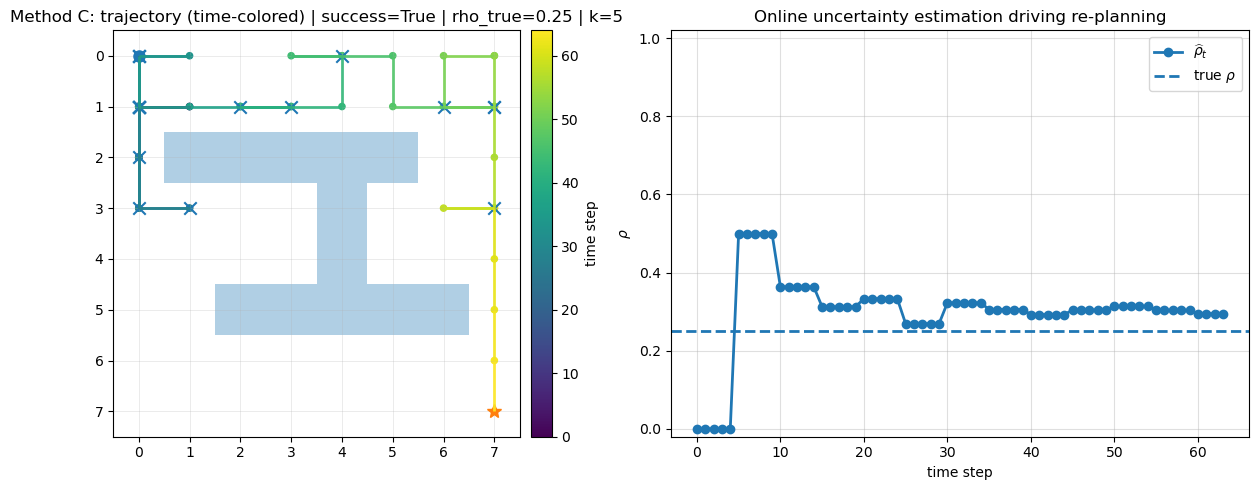

Saved: figs/agentic_replanning_adaptivity.pdf
Saved: figs/agentic_replanning_adaptivity.png


In [15]:
# ------------------------------------------------------------
# Adaptivity diagnostic (Method C): trajectory + rho-hat tracking
# ------------------------------------------------------------
# This figure isolates the adaptive mechanism inside Method C:
# - Top: one representative trajectory (colored by time)
# - Bottom: online estimate rho_hat(t) vs true rho

ADAPT_EP_TRIES = 200  # try multiple episodes to find a successful run
ADAPT_BUDGET = int(budgets[-1])
ADAPT_K = 5
if 'plot_grid' not in globals():
    # plotting helpers are defined later in the notebook; define them here for this cell
    def plot_grid(ax, walls, start, goal):
        n = walls.shape[0]
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, n-0.5)
        ax.set_ylim(n-0.5, -0.5)
        for r in range(n):
            for c in range(n):
                if walls[r,c]:
                    ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, fill=True, alpha=0.35))
        ax.plot(start[1], start[0], marker='o', markersize=8)
        ax.plot(goal[1], goal[0], marker='*', markersize=10)
        ax.set_xticks(range(n))
        ax.set_yticks(range(n))
        ax.grid(True, linewidth=0.5, alpha=0.35)

    def plot_traj(ax, traj, label=None):
        if traj is None or len(traj) < 2:
            return
        xs = [s[1] for s in traj]
        ys = [s[0] for s in traj]
        ax.plot(xs, ys, linewidth=2, alpha=0.9, label=label)



def run_episode_with_rhohat_trace(walls, start, goal, rho_true,
                                 step_cost=0.05, gamma=0.99, tau=0.05,
                                 T_max=70, plan_T=10, budget=200, k_replan=5, rng=None,
                                 budget_cap=200, rho_init=0.2):
    """Method C episode with an explicit rho_hat trace."""
    if rng is None:
        rng = np.random.default_rng(0)

    rho_hat_trace = []
    slipped_trace = []
    budget_eff = int(min(budget, budget_cap))

    s = start
    traj = [s]
    slips_obs = 0
    steps_obs = 0
    rho_hat = float(rho_init)

    for t in range(T_max):
        # plan using current rho_hat
        a_int = plan_by_sampling(s, walls, goal, rho_hat, step_cost, plan_T, budget_eff, rng, top_m=5)

        # step with true rho
        s_next, _, slipped, _ = step_env(s, a_int, walls, goal, rho_true, rng)

        slips_obs += int(slipped)
        steps_obs += 1

        # update rho_hat every k_replan steps (including at t=0)
        if (t % k_replan) == 0:
            rho_hat = estimate_rho(slips_obs, steps_obs)

        rho_hat_trace.append(rho_hat)
        slipped_trace.append(int(slipped))

        s = s_next
        traj.append(s)
        if s == goal:
            return True, traj, rho_hat_trace, slipped_trace
    return False, traj, rho_hat_trace, slipped_trace

# Choose a representative episode (prefer success, else shortest failure)
best = None
best_len = 10**9
best_success = False
for trial in range(1, ADAPT_EP_TRIES + 1):
    ok, traj_c, rho_hat_tr, slipped_tr = run_episode_with_rhohat_trace(
        walls, start, goal, rho_true,
        step_cost=step_cost, gamma=gamma, tau=tau,
        T_max=T_max, plan_T=plan_T, budget=ADAPT_BUDGET, k_replan=ADAPT_K,
        rng=rng, budget_cap=200, rho_init=0.2
    )
    L = len(traj_c)
    if ok:
        best = (ok, traj_c, rho_hat_tr, slipped_tr)
        best_success = True
        break
    if L < best_len:
        best = (ok, traj_c, rho_hat_tr, slipped_tr)
        best_len = L
    if trial % 25 == 0:
        print(f"[adapt] tried {trial}/{ADAPT_EP_TRIES}; best_success={best_success}; best_len={best_len}")

ok, traj_c, rho_hat_tr, slipped_tr = best
print("[adapt] selected episode success:", ok, "steps:", len(traj_c)-1)

OUT_ADAPT_PDF = os.path.join(FIG_DIR, 'agentic_replanning_adaptivity.pdf')
OUT_ADAPT_PNG = os.path.join(FIG_DIR, 'agentic_replanning_adaptivity.png')

# ---- Plot in a single row: trajectory | rho-hat trace ----
from matplotlib.collections import LineCollection

fig = plt.figure(figsize=(13, 5))

# Left: trajectory colored by time
axT = fig.add_subplot(1, 2, 1)
plot_grid(axT, walls, start, goal)

xs = np.array([s[1] for s in traj_c], dtype=float)
ys = np.array([s[0] for s in traj_c], dtype=float)
t_idx = np.arange(len(traj_c), dtype=float)

# Build line segments and color them by time (readable time-gradient)
points = np.column_stack([xs, ys]).reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, array=t_idx[:-1], linewidths=2, alpha=0.9)
axT.add_collection(lc)

# Also show points, colored by time (used for the colorbar)
sc = axT.scatter(xs, ys, c=t_idx, s=20)
axT.set_title(f"Method C: trajectory (time-colored) | success={ok} | rho_true={rho_true} | k={ADAPT_K}")

cbar = fig.colorbar(sc, ax=axT, fraction=0.046, pad=0.02)
cbar.set_label("time step")

# Mark slip events: crosses at the state BEFORE the slip (aligned with slipped_trace)
slip_steps = [i for i, v in enumerate(slipped_tr) if v == 1]
if len(slip_steps) > 0:
    axT.scatter(xs[np.array(slip_steps)], ys[np.array(slip_steps)], marker='x', s=80)

# Right: rho-hat tracking
axR = fig.add_subplot(1, 2, 2)
axR.plot(np.arange(len(rho_hat_tr)), rho_hat_tr, marker='o', linewidth=2, label=r'$\widehat{\rho}_t$')
axR.axhline(rho_true, linestyle='--', linewidth=2, label=r'true $\rho$')
axR.set_xlabel('time step')
axR.set_ylabel(r'$\rho$')
axR.set_title('Online uncertainty estimation driving re-planning')
axR.set_ylim(-0.02, 1.02)
axR.grid(True, alpha=0.4)
axR.legend()

plt.tight_layout()
plt.savefig(OUT_ADAPT_PDF, bbox_inches='tight')
plt.savefig(OUT_ADAPT_PNG, dpi=200, bbox_inches='tight')
plt.show()

print('Saved:', OUT_ADAPT_PDF)
print('Saved:', OUT_ADAPT_PNG)


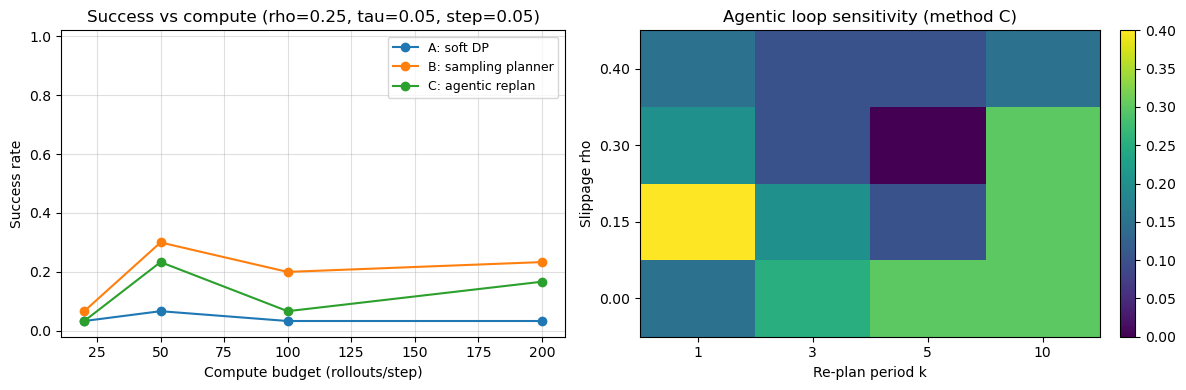

Saved: figs/agentic_replanning_gridworld_summary.pdf
Saved: figs/agentic_replanning_gridworld_summary.png


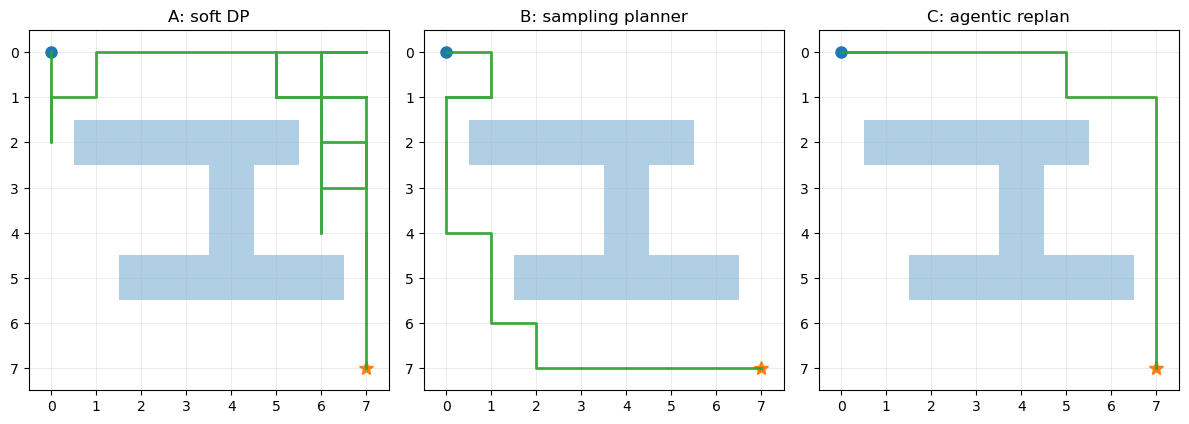

Saved: figs/agentic_replanning_trajectories.pdf
Saved: figs/agentic_replanning_trajectories.png


In [13]:
# ------------------------------------------------------------
# Plot summary figures and save to figs/ (PDF + PNG)
# ------------------------------------------------------------
OUT_PDF = OUT_FIG
OUT_PNG = OUT_FIG.replace('.pdf', '.png')
OUT_PDF2 = os.path.join(FIG_DIR, 'agentic_replanning_trajectories.pdf')
OUT_PNG2 = os.path.join(FIG_DIR, 'agentic_replanning_trajectories.png')

def plot_grid(ax, walls, start, goal):
    n = walls.shape[0]
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    for r in range(n):
        for c in range(n):
            if walls[r,c]:
                ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, fill=True, alpha=0.35))
    ax.plot(start[1], start[0], marker='o', markersize=8)
    ax.plot(goal[1], goal[0], marker='*', markersize=10)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.grid(True, linewidth=0.5, alpha=0.35)

def plot_traj(ax, traj, label=None):
    if traj is None or len(traj) < 2:
        return
    xs = [s[1] for s in traj]
    ys = [s[0] for s in traj]
    ax.plot(xs, ys, linewidth=2, alpha=0.9, label=label)

# ---- Figure 1: Success vs compute + Sensitivity ----
fig1 = plt.figure(figsize=(12,4))
ax1 = fig1.add_subplot(1,2,1)
ax1.plot(budgets, rates_A, marker='o', label='A: soft DP')
ax1.plot(budgets, rates_B, marker='o', label='B: sampling planner')
ax1.plot(budgets, rates_C, marker='o', label='C: agentic replan')
ax1.set_xlabel('Compute budget (rollouts/step)')
ax1.set_ylabel('Success rate')
ax1.set_title(f'Success vs compute (rho={rho_true}, tau={tau}, step={step_cost})')
ax1.set_ylim(-0.02, 1.02)
ax1.grid(True, alpha=0.4)
ax1.legend(fontsize=9)

ax2 = fig1.add_subplot(1,2,2)
im = ax2.imshow(sens, aspect='auto', origin='lower')
ax2.set_xticks(np.arange(len(ks)))
ax2.set_xticklabels([str(k) for k in ks])
ax2.set_yticks(np.arange(len(rhos)))
ax2.set_yticklabels([f'{r:.2f}' for r in rhos])
ax2.set_xlabel('Re-plan period k')
ax2.set_ylabel('Slippage rho')
ax2.set_title('Agentic loop sensitivity (method C)')
fig1.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(OUT_PDF, bbox_inches='tight')
plt.savefig(OUT_PNG, dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', OUT_PDF)
print('Saved:', OUT_PNG)

# ---- Figure 2: Trajectories (one panel per method; only if successful) ----
fig2 = plt.figure(figsize=(12,4))
axes = [fig2.add_subplot(1,3,i+1) for i in range(3)]
for ax in axes:
    plot_grid(ax, walls, start, goal)

axes[0].set_title('A: soft DP' + ('' if okA else ' (no success found)'))
if okA:
    plot_traj(axes[0], trA, label='A')

axes[1].set_title('B: sampling planner' + ('' if okB else ' (no success found)'))
if okB:
    plot_traj(axes[1], trB, label='B')

axes[2].set_title('C: agentic replan' + ('' if okC else ' (no success found)'))
if okC:
    plot_traj(axes[2], trC, label='C')

plt.tight_layout()
plt.savefig(OUT_PDF2, bbox_inches='tight')
plt.savefig(OUT_PNG2, dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', OUT_PDF2)
print('Saved:', OUT_PNG2)
